In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle, Arc
import numpy as np
import matplotlib.image as mpimg  

In [30]:
shots_df = pd.read_csv('C:/Users/pitom/OneDrive/Desktop/materiale uni/data-vis/esame/shots_team_year.csv')
shots_df = shots_df[(shots_df['LOC_X'] != 0) | (shots_df['LOC_Y'] != 0)]
shots_df['SHOT_DISTANCE'] = np.sqrt(shots_df['LOC_X']**2 + shots_df['LOC_Y']**2)
shots_df['IN_PAINT'] = (shots_df['LOC_X'].abs() <= 80) & (shots_df['LOC_Y'] <= 142.5)
shots_df['IS_THREE'] = (
    ((shots_df['LOC_X'].abs() > 220) & (shots_df['LOC_Y'] <= 89)) |  # angoli
    (shots_df['SHOT_DISTANCE'] > 237.5)  # distanza > 23.75 piedi
)
shots_df['MID_RANGE'] = ~(shots_df['IN_PAINT'] | shots_df['IS_THREE'])
shots_df['SHOT_TYPE'] = np.select(
    [
        shots_df['IN_PAINT'],
        shots_df['IS_THREE'],
        shots_df['MID_RANGE']
    ],
    [
        'In the Paint',
        'Three Points',
        'Mid Range'
    ],
    default='Other'
)
print(shots_df[(shots_df['LOC_X'] == 0) & (shots_df['LOC_Y'] == 0)].shape[0])
shots_df.head()

0


TEAM_NAME  LOC_X  LOC_Y   SEASON  SHOT_DISTANCE  IN_PAINT  IS_THREE  \
1    Chicago Bulls     45    148  1996-97     154.690013     False     False   
2   Boston Celtics    163    122  1996-97     203.600098     False     False   
6    Chicago Bulls    -12     75  1996-97      75.953933      True     False   
8   Boston Celtics   -244    -16  1996-97     244.524027     False      True   
10   Chicago Bulls    205    101  1996-97     228.530086     False     False   

    MID_RANGE     SHOT_TYPE  
1        True     Mid Range  
2        True     Mid Range  
6       False  In the Paint  
8       False  Three Points  
10       True     Mid Range

In [32]:
nba_finals = [
    ("Chicago Bulls", "Seattle SuperSonics"),   
    ("Chicago Bulls", "Utah Jazz"),             
    ("Chicago Bulls", "Utah Jazz"),             
    ("San Antonio Spurs", "New York Knicks"),   
    ("Los Angeles Lakers", "Indiana Pacers"),   
    ("Los Angeles Lakers", "Philadelphia 76ers"),
    ("Los Angeles Lakers", "New Jersey Nets"),  
    ("San Antonio Spurs", "New Jersey Nets"),   
    ("Detroit Pistons", "Los Angeles Lakers"),  
    ("San Antonio Spurs", "Detroit Pistons"),   
    ("Miami Heat", "Dallas Mavericks"),         
    ("San Antonio Spurs", "Cleveland Cavaliers"),
    ("Boston Celtics", "Los Angeles Lakers"),   
    ("Los Angeles Lakers", "Orlando Magic"),    
    ("Los Angeles Lakers", "Boston Celtics"),   
    ("Dallas Mavericks", "Miami Heat"),         
    ("Miami Heat", "Oklahoma City Thunder"),    
    ("Miami Heat", "San Antonio Spurs"),        
    ("San Antonio Spurs", "Miami Heat"),        
    ("Golden State Warriors", "Cleveland Cavaliers"), 
    ("Cleveland Cavaliers", "Golden State Warriors"), 
    ("Golden State Warriors", "Cleveland Cavaliers"), 
    ("Golden State Warriors", "Cleveland Cavaliers"), 
    ("Toronto Raptors", "Golden State Warriors"),     
    ("Los Angeles Lakers", "Miami Heat"),      
    ("Milwaukee Bucks", "Phoenix Suns"),        
    ("Golden State Warriors", "Boston Celtics"),
    ("Denver Nuggets", "Miami Heat"),           
    ("Boston Celtics", "Dallas Mavericks")      
]

In [65]:
def make_shot_heatmap(shots_df,Teams=0, stagioni_scelte=0, examples = 0,ax=None):
    def draw_court(ax=None, color='black', lw=2, outer_lines=False):
        if ax is None:
            ax = plt.gca()
        hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
        backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
        outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color, fill=False)
        inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color, fill=False)
        free_throw_top = Arc((0, 142.5), 120, 120, theta1=0, theta2=180, linewidth=lw, color=color, fill=False)
        free_throw_bottom = Arc((0, 142.5), 120, 120, theta1=180, theta2=0, linewidth=lw, color=color, linestyle='dashed')
        restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw, color=color)
        corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw, color=color)
        corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
        three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw, color=color)
        center_circle = Arc((0, 422.5), 120, 120, theta1=0, theta2=360, linewidth=lw, color=color)
        court_elements = [hoop, backboard, outer_box, inner_box,
                          free_throw_top, free_throw_bottom, restricted,
                          corner_three_a, corner_three_b, three_arc,
                          center_circle]
        if outer_lines:
            outer = Rectangle((-250, -47.5), 500, 470, linewidth=lw, color=color, fill=False)
            court_elements.append(outer)
        for element in court_elements:
            ax.add_patch(element)
        return ax

    if examples == 0:
        sample_df = shots_df
    elif examples < 50000:
        sample_df = shots_df.sample(50000)
    else:
        sample_df = shots_df.sample(examples)

    if stagioni_scelte != 0:
        df = sample_df[sample_df['SEASON'].isin(stagioni_scelte)]  
    else:
        df = sample_df

    if Teams != 0:
        df = df[df['TEAM_NAME'].isin(Teams)]

    # Crea fig solo se ax non è passato
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 9))
    else:
        fig = ax.figure

#E6BE8A (legno chiaro)
#D2B48C (tan)
#DEB887 (burlywood)
#C19A6B (wood)
    ax.set_facecolor('#F4E1C1')
    hb = ax.hexbin(
        x=df['LOC_X'],
        y=df['LOC_Y'],
        gridsize=70,
        extent=(-250, 250, -50, 470),
        cmap='Reds',
        bins='log',
        mincnt=1,
        alpha= 0.8,
        vmax=1000
    )



    draw_court(ax, outer_lines=True)

    ax.axis('off')
    ax.set_title(f"Heatmap {stagioni_scelte}", fontsize=15)

    if hb.get_array().size > 0 and np.all(np.isfinite(hb.get_array())):
        cbar = fig.colorbar(hb, ax=ax)
        cbar.set_label('Numero di tiri (log)', fontsize=13)
    
    return fig, ax

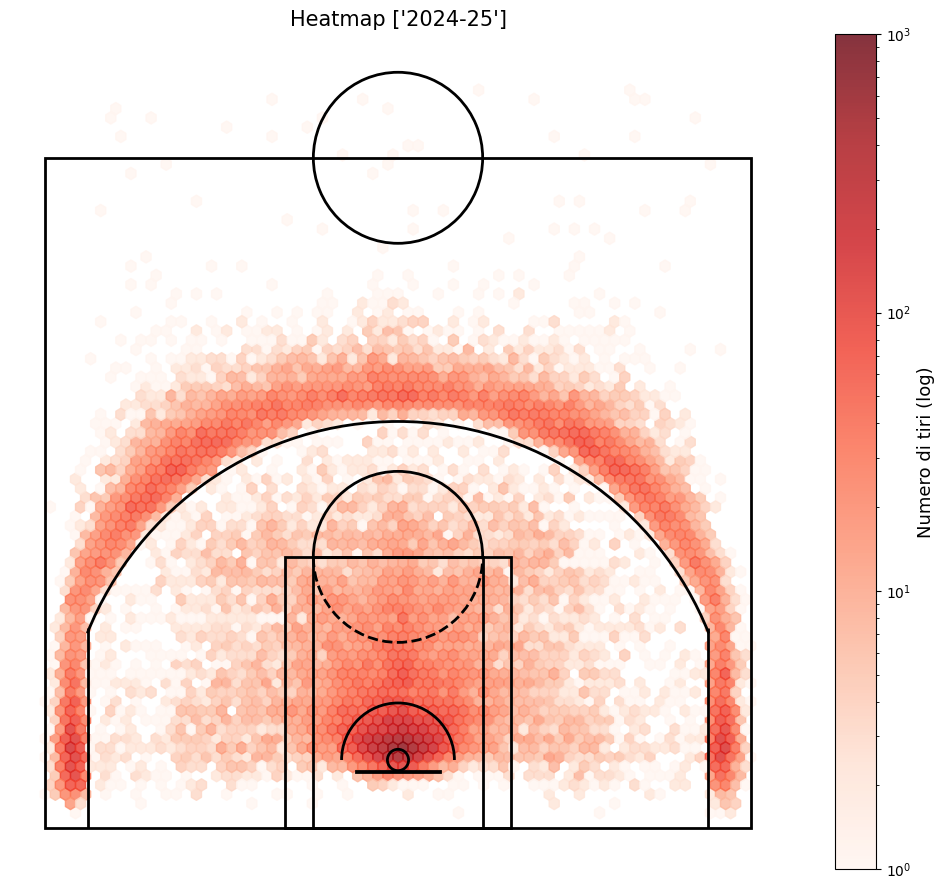

In [72]:
_, ax = make_shot_heatmap(shots_df,stagioni_scelte=['2024-25'], examples=1000000)

plt.tight_layout()
plt.show()

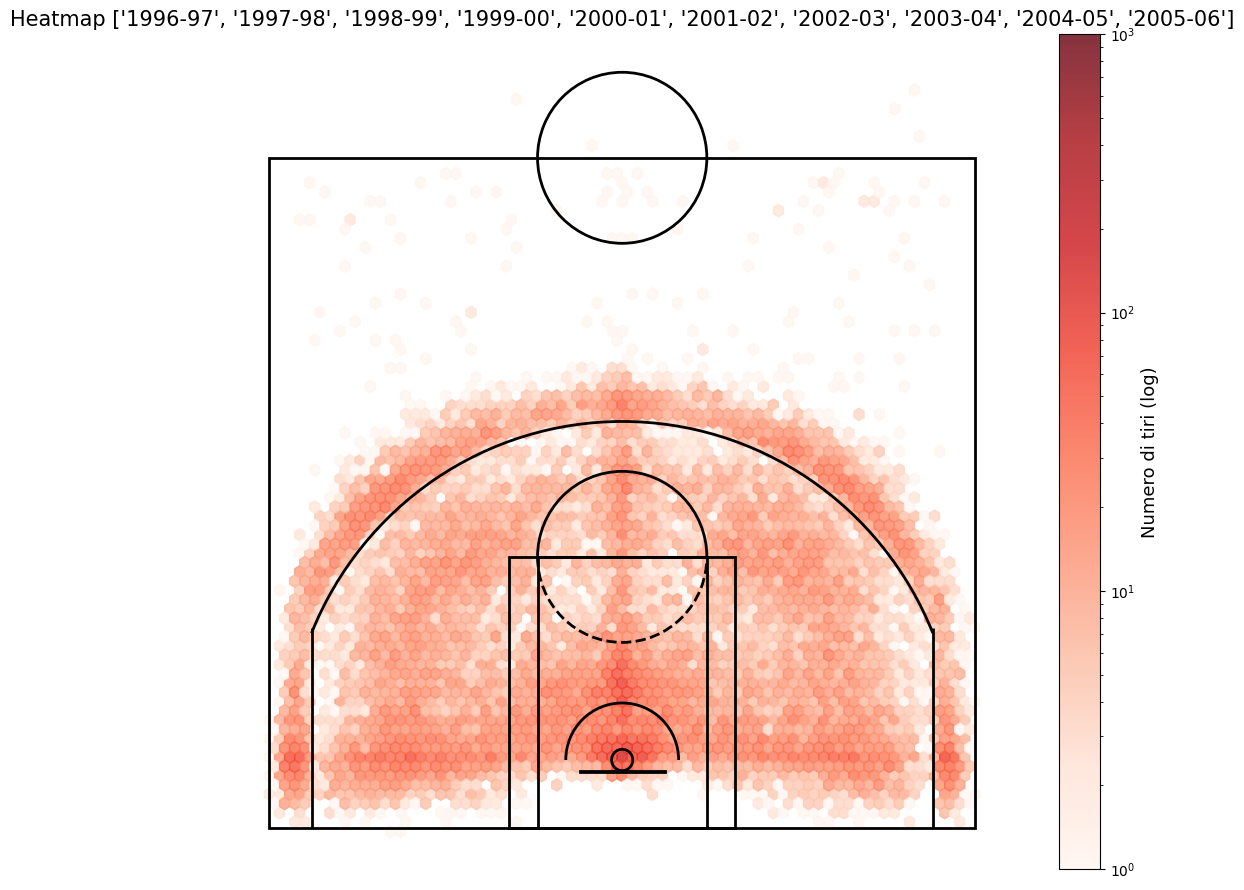

In [68]:
seasons = [f"{year}-{str(year+1)[2:]}" for year in range(1996, 2006)]
_, ax = make_shot_heatmap(shots_df,stagioni_scelte=seasons, examples=100000)

plt.tight_layout()
plt.show()

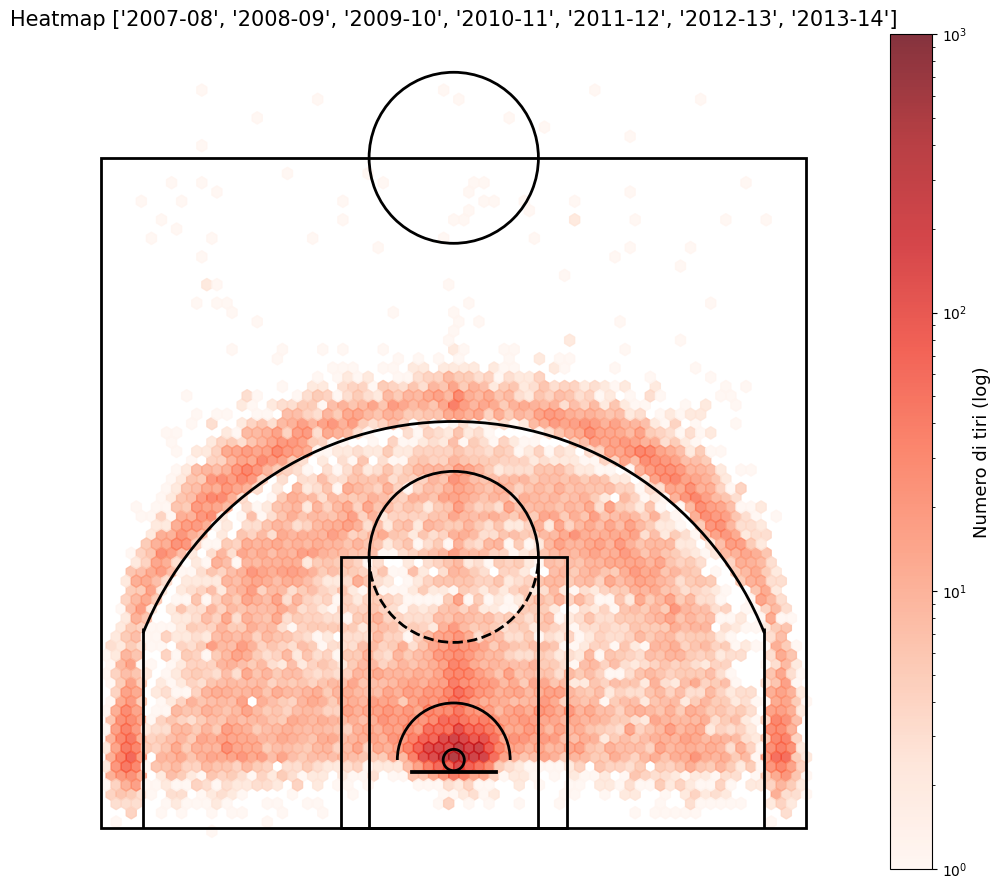

In [69]:
seasons = [f"{year}-{str(year+1)[2:]}" for year in range(2007, 2014)]
_, ax = make_shot_heatmap(shots_df,stagioni_scelte=seasons, examples=100000)

plt.tight_layout()
plt.show()

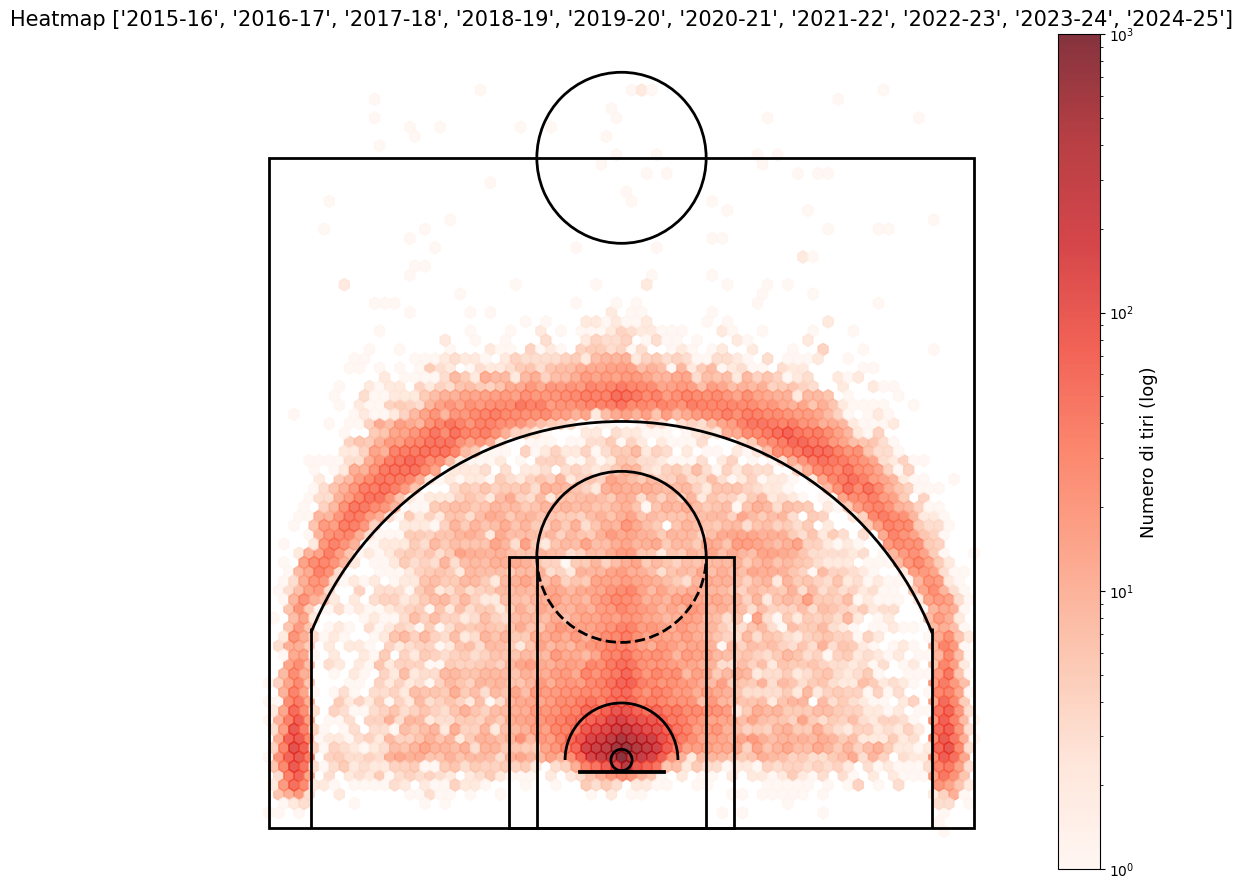

In [67]:
seasons = [f"{year}-{str(year+1)[2:]}" for year in range(2015, 2025)]
_, ax = make_shot_heatmap(shots_df,stagioni_scelte=seasons, examples=100000)

plt.tight_layout()
plt.show()

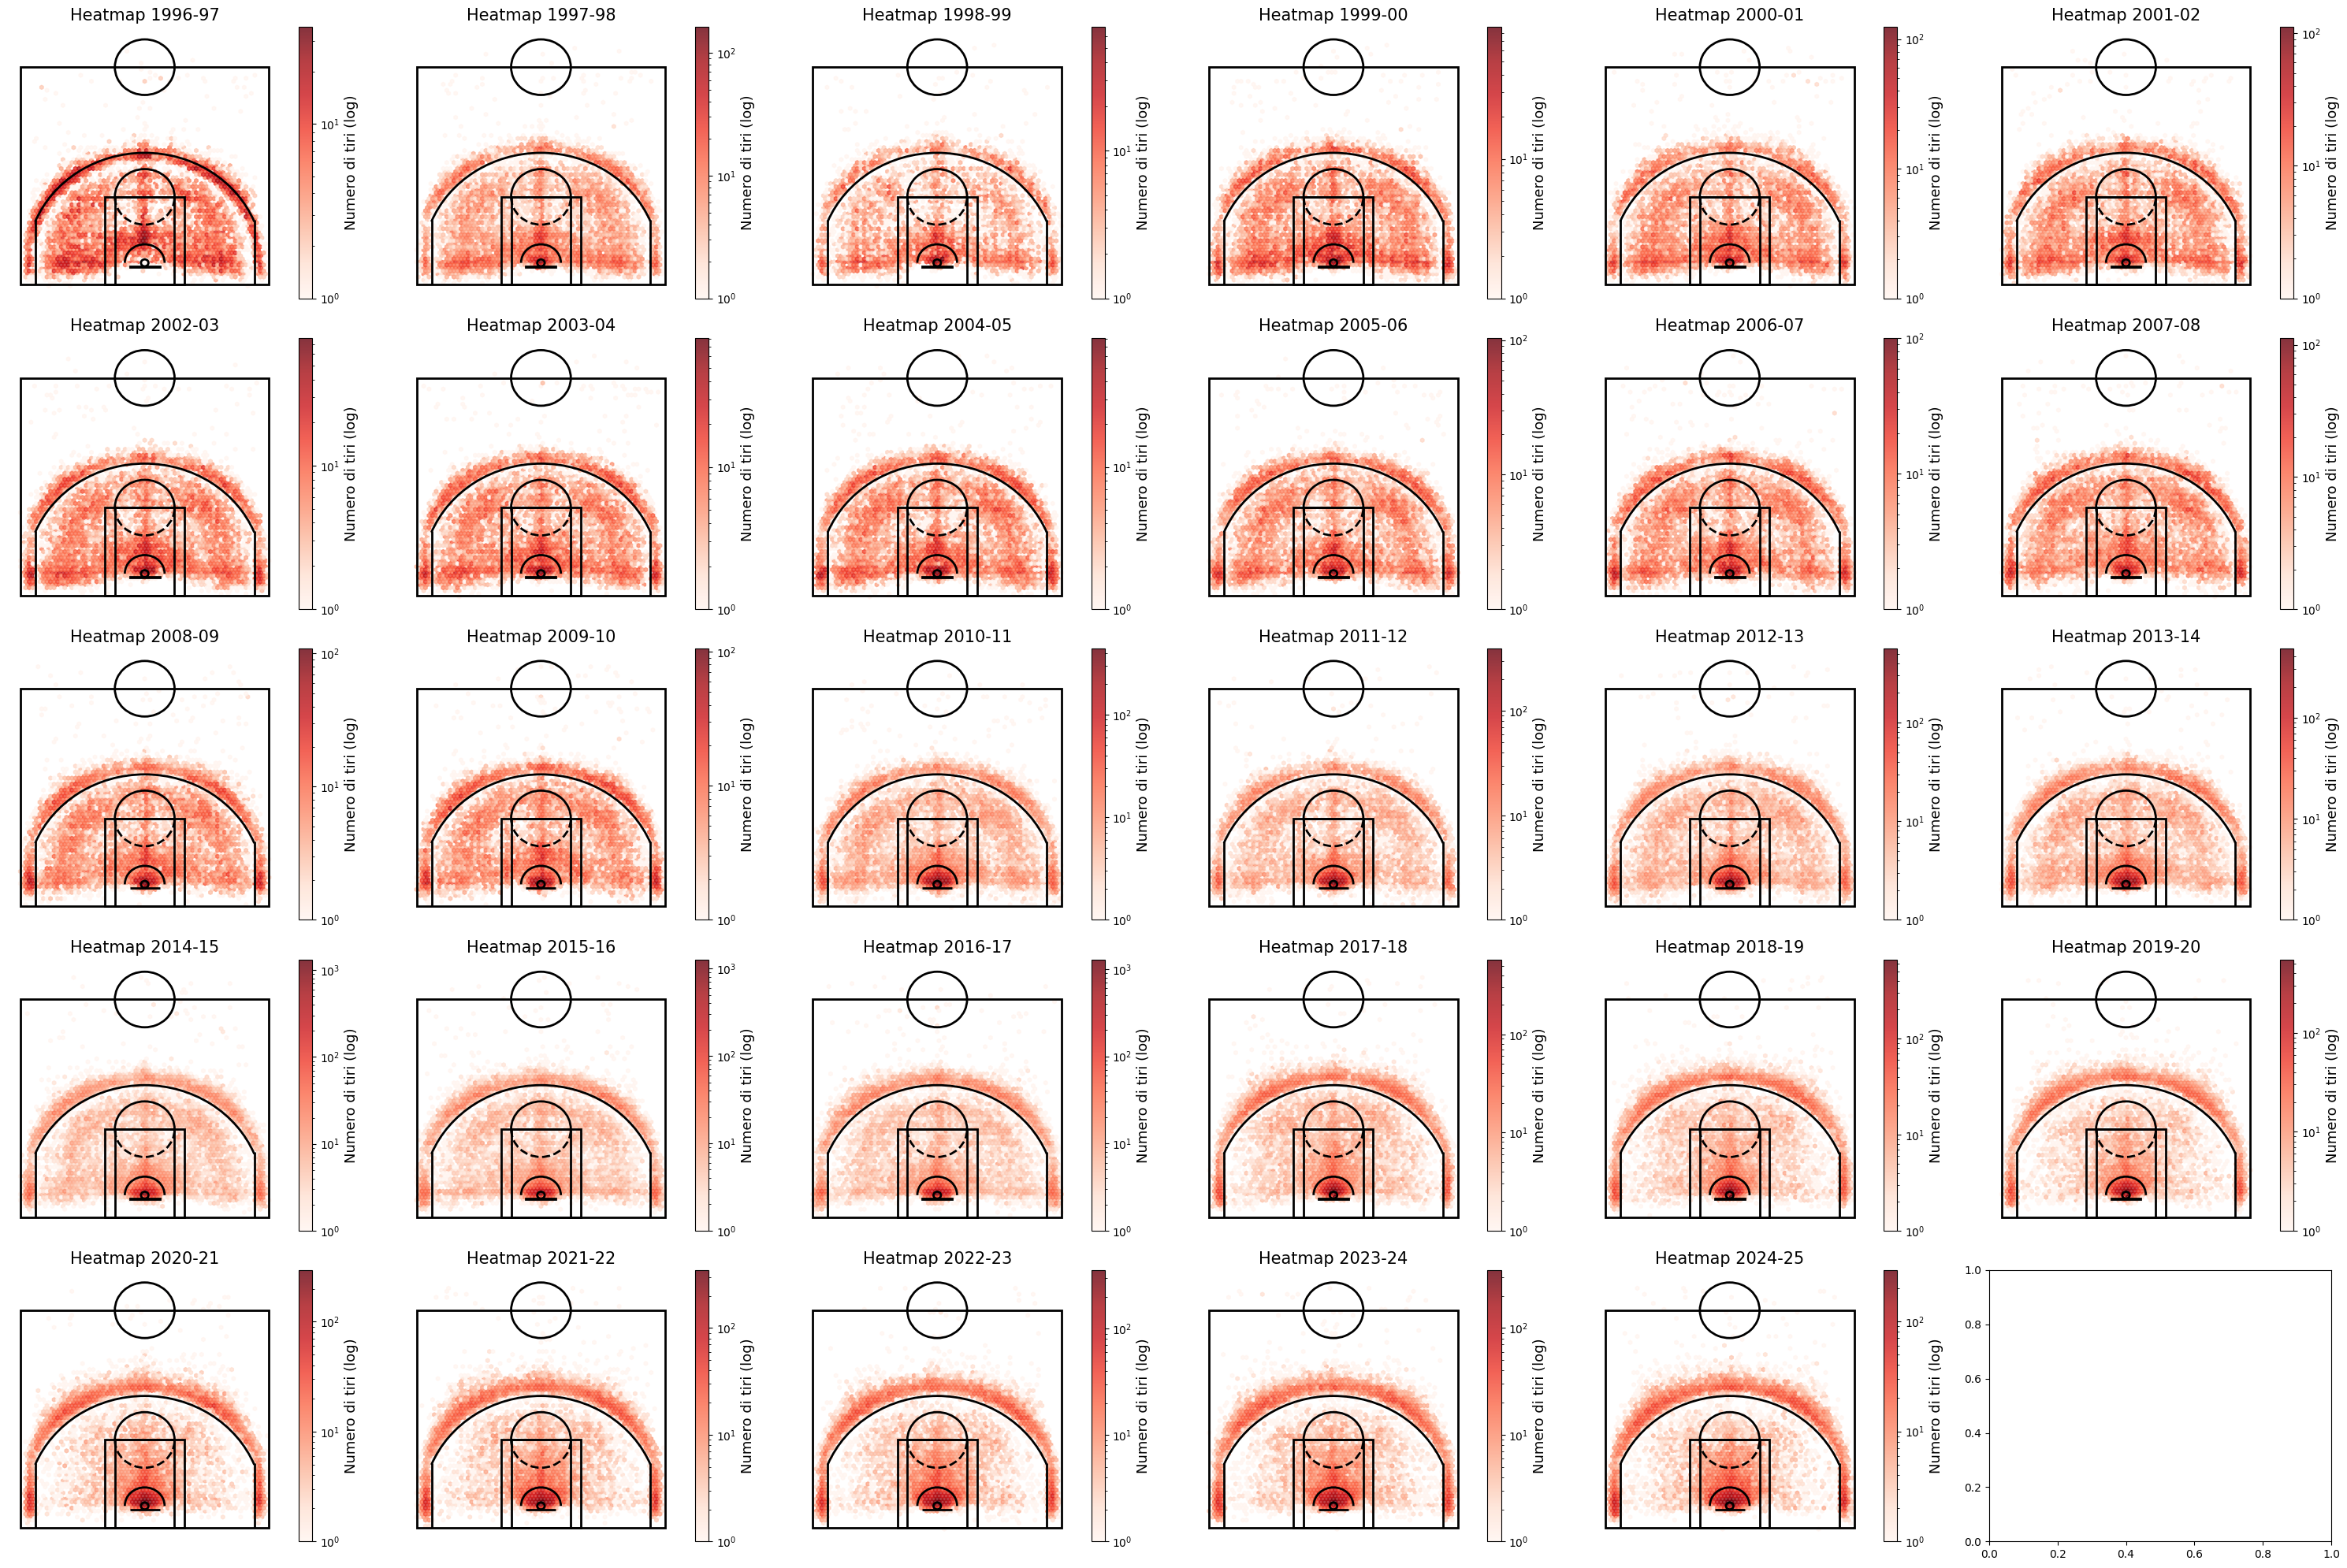

In [ ]:
seasons = [f"{year}-{str(year+1)[2:]}" for year in range(1996, 2025)]
fig, axs = plt.subplots(5,6 , figsize=(30, 20))  # 25 stagioni

for i, season in enumerate(seasons):
    row, col = divmod(i, 6)
    _, ax = make_shot_heatmap(shots_df,stagioni_scelte=season, examples=500000,ax=axs[row][col])

plt.tight_layout()
plt.show()

In [5]:
seasons = [f"{year}-{str(year+1)[2:]}" for year in range(1996, 2025)]

finals_teams_per_season = [
    {'SEASON': season, 'TEAM_NAME': winner}
    for season, (winner, _) in zip(seasons, nba_finals)
] + [
    {'SEASON': season, 'TEAM_NAME': finalist}
    for season, (_, finalist) in zip(seasons, nba_finals)
]


finalists_df = pd.DataFrame(finals_teams_per_season)
finals_shots = shots_df.merge(finalists_df, on=['SEASON', 'TEAM_NAME'])

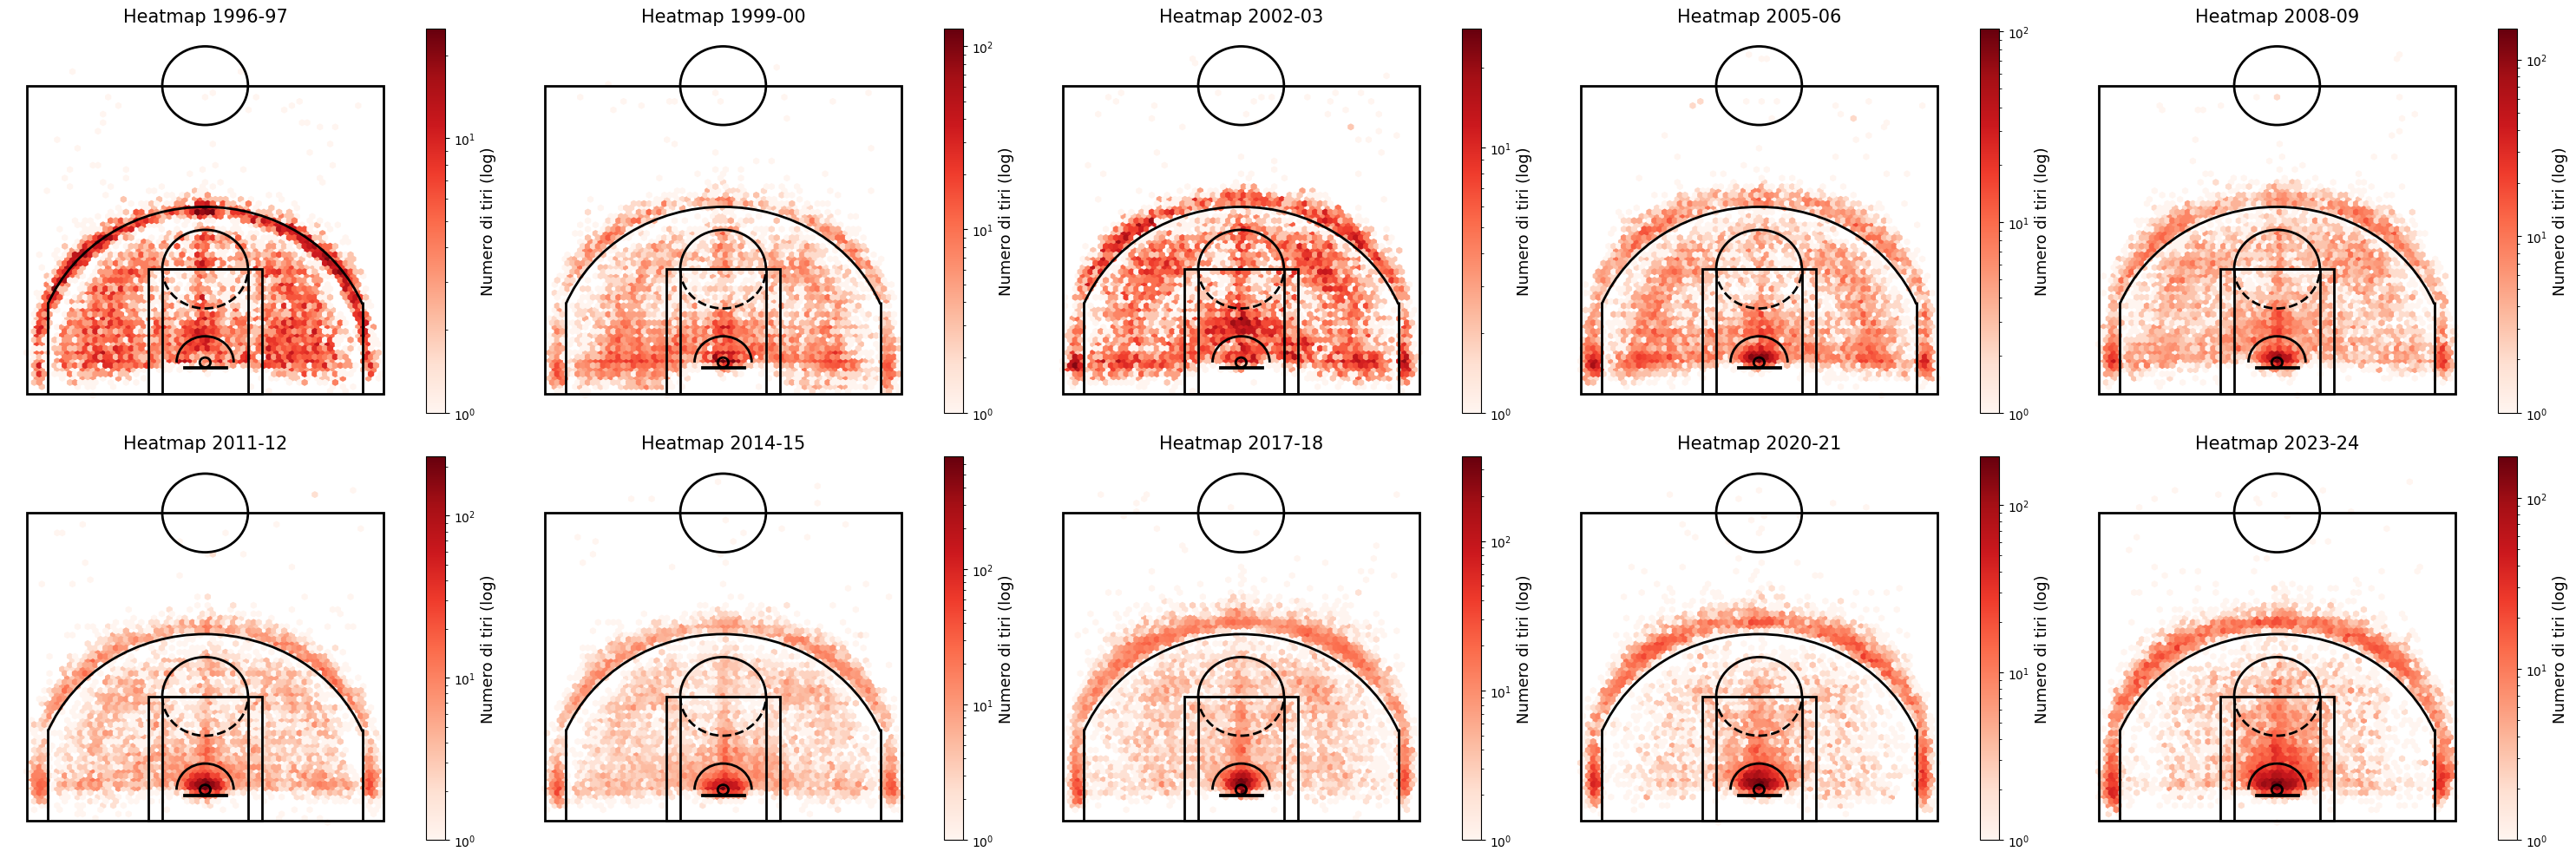

In [13]:
seasons = [f"{year}-{str(year+1)[2:]}" for year in range(1996, 2025)]
seasons = seasons[::3]
fig, axs = plt.subplots(2,5 , figsize=(30, 10))  

for i, season in enumerate(seasons):
    row, col = divmod(i, 5)
    _, ax = make_shot_heatmap(finals_shots,stagioni_scelte=season, examples=0,ax=axs[row][col])

plt.tight_layout()
plt.show()

In [33]:

counts = finals_shots.groupby(['SEASON', 'SHOT_TYPE']).size().unstack(fill_value=0)
percentages = counts.div(counts.sum(axis=1), axis=0) * 100
percentages = percentages[['Mid Range','In the Paint', 'Three Points']]
percentages = percentages.iloc[::-1]
percentages

SHOT_TYPE  Mid Range  In the Paint  Three Points
SEASON                                          
2024-25    10.037826     42.637994     47.324180
2023-24    12.806853     48.873371     38.319775
2022-23     9.728443     41.111422     49.160134
2021-22    15.963290     43.989432     40.047278
2020-21    13.437578     46.057363     40.505059
2019-20    13.608094     47.624181     38.767725
2018-19    19.709786     44.556771     35.733443
2017-18    21.231057     42.986425     35.782518
2016-17    19.957432     42.206456     37.836112
2015-16    19.839008     44.472147     35.688845
2014-15    26.149294     47.276589     26.574116
2013-14    25.337400     47.327488     27.335112
2012-13    27.830960     45.754533     26.414507
2011-12    30.864081     45.660768     23.475151
2010-11    31.748112     48.180977     20.070911
2009-10    35.090797     25.670656     39.238547
2008-09    37.989892     34.804997     27.205111
2007-08    37.869052     34.960056     27.170893
2006-07    43.900896     25.260938     30.838166
2005-06    43.780905     29.583492     26.635603
2004-05    46.603630     22.312792     31.083578
2003-04    44.603601     32.985179     22.411221
2002-03    49.167452     25.709498     25.123050
2001-02    49.548811     28.394176     22.057014
2000-01    43.367914     34.105224     22.526862
1999-00    49.322231     33.249419     17.428350
1998-99    54.672456     26.656598     18.670946
1997-98    59.656604     22.197284     18.146112
1996-97    65.319982     19.060773     15.619245